In [114]:
import json
import numpy as np
import pandas as pd
import time
import math
import numpy

import sys
sys.path.append('../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, export_StochSS
from gillespy2 import ODECSolver, ODESolver, SSACSolver
from gillespy2 import TauHybridCSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

from scipy import spatial
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
import random

# Devils DFTD Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [11]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)
dates = []
year = 1985
while len(dates) < len(devil_pop):
    for month in ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]:
        dates.append(f"{month} {year}")
    year += 1

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
carry_cap = int(max(devil_pop)*1.16)


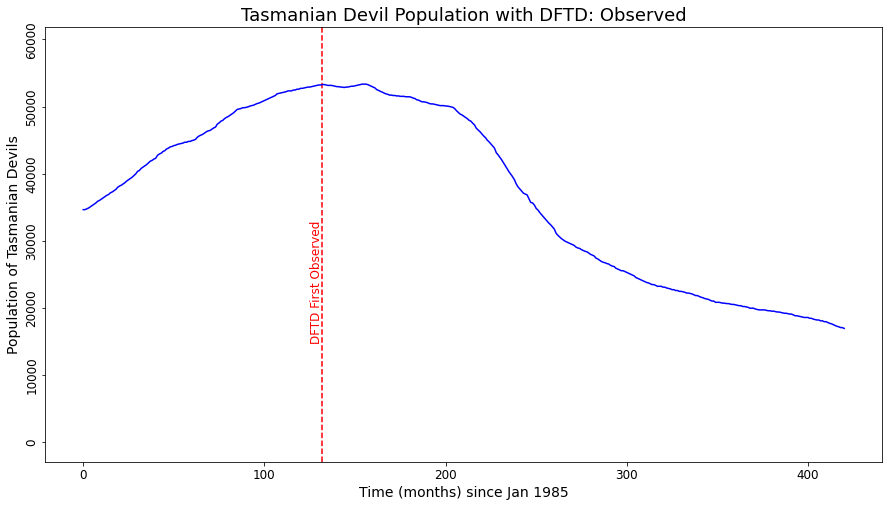

In [12]:
plt.figure(figsize=[15, 8])
plt.title("Tasmanian Devil Population with DFTD: Observed", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=14)
plt.ylabel("Population of Tasmanian Devils", fontsize=14)
plt.plot([132, 132], [-3000, max(devil_pop)*1.16], '--r')
plt.ylim([-3000, max(devil_pop)*1.16])
plt.text(125, 15000, "DFTD First Observed", rotation="vertical", color="red", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation="vertical", va="center")
_ = plt.plot(range(len(devil_pop)), devil_pop, 'b', label='Observed Total')

## Model

In [106]:
variables = {
    "juvenile_concentration": 0.467,
    "infected_concentration": 5e-5,
    "birth_rate": 0.055,
    "maturity_rate": 0.04267,
    "infection_rate_infected": 1.675e-05,
    "infection_rate_diseased": 4e-05,
    "incubation": 19,
    "progression": 12,
    "death_rate_juvenile": 0.006,
    "death_rate_susceptible": 0.02335,
    "death_rate_over_population": 2.3e-7,
    "death_rate_infected": 0.02,
    "death_rate_diseased": 0.024,
    "DFTD_start": 95
}
variables_orig = variables.copy()

In [155]:
import json

In [157]:
json.dumps(variables)

'{"juvenile_concentration": 0.467, "infected_concentration": 5e-05, "birth_rate": 0.055, "maturity_rate": 0.04267, "infection_rate_infected": 1e-05, "infection_rate_diseased": 1e-05, "incubation": 6, "progression": 10, "death_rate_juvenile": 0.006, "death_rate_susceptible": 0.02335, "death_rate_over_population": 2.3e-07, "death_rate_infected": 0.1, "death_rate_diseased": 0.35, "DFTD_start": 40}'

In [127]:
class DevilsPreVaccination(Model):
    def __init__(self, values=variables, events=None):
        Model.__init__(self, name="Devils DFTD 2-Stage Infection")
        self.volume = 1
        self._saved_values = values.copy()

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression=values['birth_rate'])
        death_rate_juvenile = Parameter(name="death_rate_juvenile", expression=values['death_rate_juvenile'])
        maturity_rate = Parameter(name="maturity_rate", expression=values['maturity_rate'])
        death_rate_susceptible = Parameter(
            name="death_rate_susceptible", expression=values['death_rate_susceptible']
        )
        death_rate_over_population = Parameter(
            name="death_rate_over_population", expression=values['death_rate_over_population']
        )
        infection_rate_infected = Parameter(
            name="infection_rate_infected", expression=values['infection_rate_infected']
        )
        infection_rate_diseased = Parameter(
            name="infection_rate_diseased", expression=values['infection_rate_diseased']
        )
        incubation = Parameter(name="incubation", expression=values['incubation'])
        death_rate_infected = Parameter(name="death_rate_infected", expression=values['death_rate_infected'])
        progression = Parameter(name="progression", expression=values['progression'])
        death_rate_diseased = Parameter(name="death_rate_diseased", expression=values['death_rate_diseased'])
        DFTD_start = Parameter(name="DFTD_start", expression=values['DFTD_start'])
        self.add_parameter([birth_rate, death_rate_juvenile, maturity_rate, death_rate_susceptible,
                            death_rate_over_population, infection_rate_infected, infection_rate_diseased,
                            incubation, death_rate_infected, progression, death_rate_diseased, DFTD_start])

        # Variables (initial values adjusted to observed data)
        initial_devil_population  = int(devil_pop[0])
        
        Juvenile = Species(
            name="Juvenile", mode="discrete",
            initial_value=round(initial_devil_population * values['juvenile_concentration'])
        )
        Susceptible = Species(
            name="Susceptible", mode="discrete",
            initial_value=round(initial_devil_population * (1 - values['juvenile_concentration']))
        )
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Diseased = Species(name="Diseased", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=initial_devil_population, mode="discrete")
        self.add_species([Juvenile, Susceptible, Exposed, Infected, Diseased, Devils])

        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Juvenile': 1, 'Devils': 1},
            propensity_function="birth_rate * (Susceptible + Exposed + Infected)"
        )
        Mature = Reaction(name="Mature",
            reactants={'Juvenile': 1}, products={'Susceptible': 1},
            propensity_function="Juvenile * maturity_rate"
        )
        self.add_reaction([Birth, Mature])
        
        Death_Juvenile = Reaction(name="Death_Juvenile",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_juvenile * Juvenile"
        )
        Death_Juvenile2 = Reaction(name="Death_Juvenile2",
            reactants={'Juvenile': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Juvenile * (Devils-1)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible * Susceptible"
        )
        Death_Susceptible2 = Reaction(name="Death_Susceptible2",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Susceptible * (Devils-1)"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_infected * Infected"
        )
        Death_Infected2 = Reaction(name="Death_Infected2",
            reactants={'Infected': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Infected * (Devils-1)"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible * Exposed"
        )
        Death_Exposed2 = Reaction(name="Death_Exposed2",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_over_population * Exposed * (Devils - 1)"
        )
        Death_Diseased = Reaction(name="Death_Diseased",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_diseased * Diseased"
        )
        Death_Diseased2 = Reaction(name="Death_Diseased2",
            reactants={'Diseased': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_over_population * Diseased * (Devils - 1)"
        )
        self.add_reaction([Death_Juvenile, Death_Susceptible, Death_Exposed, Death_Infected, Death_Diseased,
                           Death_Juvenile2, Death_Susceptible2, Death_Exposed2, Death_Infected2, Death_Diseased2])
        
        
        TransmissionI = Reaction(name="TransmissionI",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected':1},
            propensity_function="infection_rate_infected * Susceptible * Infected"
        )
        TransmissionD = Reaction(name="TransmissionD",
            reactants={'Susceptible': 1, 'Diseased': 1}, products={'Exposed': 1, 'Diseased':1},
            propensity_function="infection_rate_diseased * Susceptible * Diseased"
        )
        DFTD_Stage1 = Reaction(name="DFTD_Stage1",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed / incubation"
        )
        DFTD_Stage2 = Reaction(name="DFTD_Stage2",
            reactants={'Infected': 1}, products={'Diseased': 1},
            propensity_function="Infected / progression"
        )
        self.add_reaction([TransmissionI, TransmissionD, DFTD_Stage1, DFTD_Stage2])

        # Events
        self.add_event(Event(name="DFTD_Introduction", assignments= [
            EventAssignment(variable="Infected", expression="1"),
            EventAssignment(variable="Susceptible", expression="Susceptible - 1")
        ], trigger=EventTrigger(expression=f"t >= {variables['DFTD_start']}")))

        # Timespan
        self.timespan(np.arange(0, 421, 1)) # month data tspan
        
    def run(self, number_of_trajectories=1, solver=None):
        solver = TauHybridCSolver()
        needed_num = number_of_trajectories
        num = 0
        ret_traj=[]
        while(num < needed_num):
            n = min(100,(needed_num-num))
            print(f"Running {n} trajectories", end=' ')
            sys.stdout.flush()
            tic=time.time()
            results = super().run(number_of_trajectories=n, solver=solver, seed=random.randint(0,2**31-1))
            print(f" complete in {time.time()-tic}s")
            for r in results:
                if (r['Exposed'][-1] + r['Infected'][-1] + r['Diseased'][-1]) > 0:
                    ret_traj.append(r)
                    num+=1
            
        return gillespy2.Results(ret_traj)


In [128]:
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")

Running 100 trajectories  complete in 19.88431143760681s
Running 100 trajectories  complete in 31.677502632141113s
simulation complete in 51.565752029418945s


In [129]:
len(eresults)

100

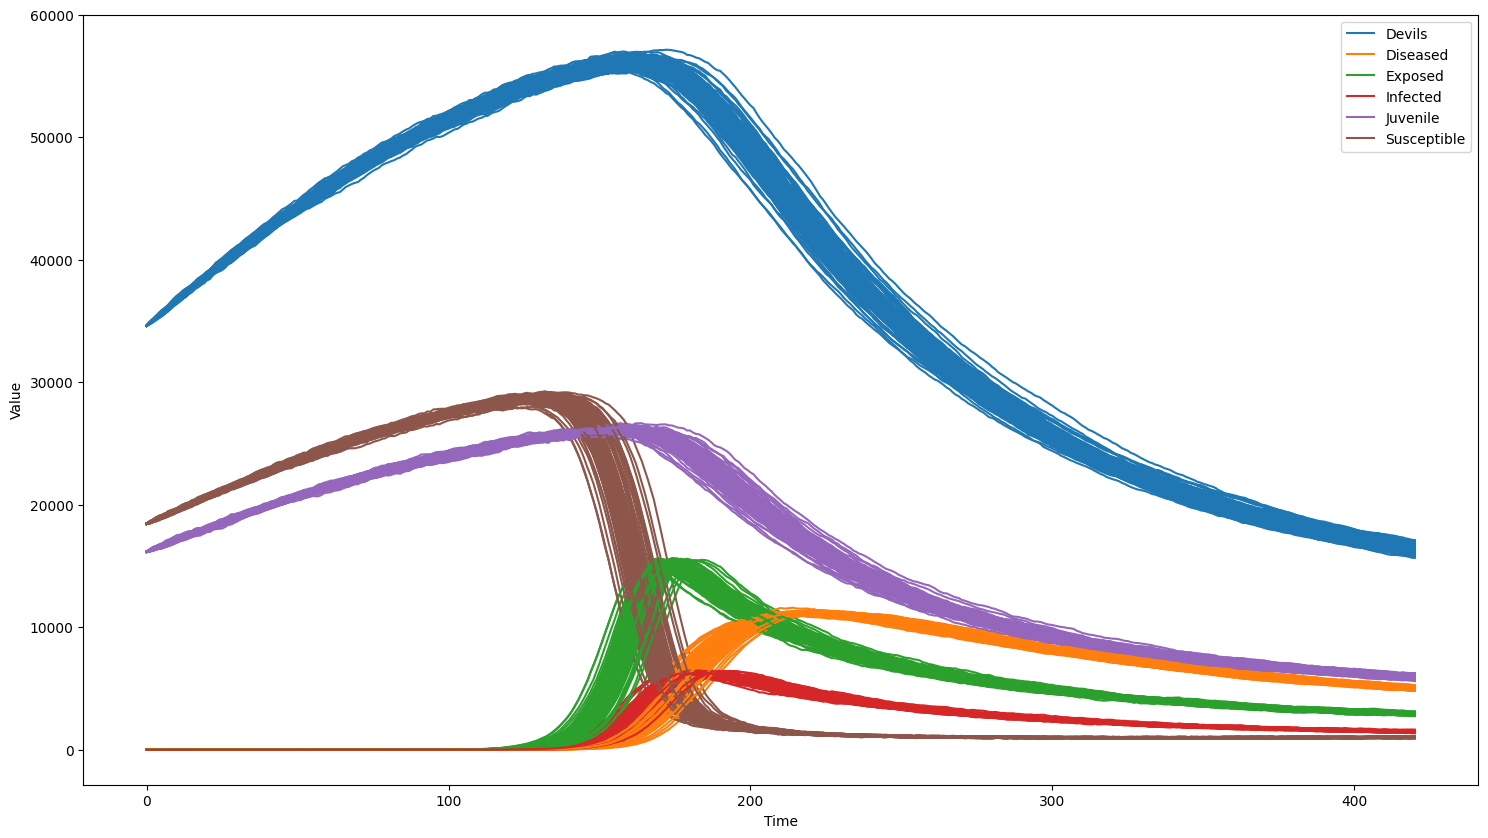

In [130]:
eresults.plot()


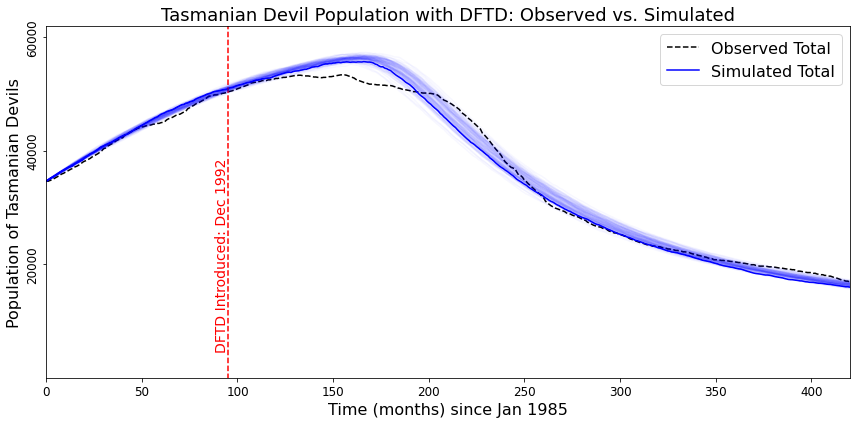

In [25]:
plt.figure(figsize=[12, 6])
plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
plt.xlabel(f"Time (months) since {dates[0]}", fontsize=16)
plt.ylabel("Population of Tasmanian Devils", fontsize=16)
plt.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
plt.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
# plt.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.3, label='Juvenile')
# plt.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.3, label='Susceptible')
# plt.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.3, label='Exposed')
# plt.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.3, label='Infected')
# plt.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.3, label='Diseased')
plt.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--r')
plt.ylim([0, carry_cap])
plt.text(variables['DFTD_start']-7, 5000, "DFTD Introduced: "+dates[variables['DFTD_start']], rotation="vertical", color="red", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks([20000,40000,60000],fontsize=12, rotation="vertical", va="center")
plt.xlim(0,eresults[0]['time'][-1])
plt.legend(loc='upper right', fontsize=16)
for n,r in enumerate(eresults):
    if n==0: continue
    plt.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
plt.tight_layout()
#plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")

In [151]:
def plot_eresult(eresults): 

    fig, ax1 = plt.subplots(figsize=[12, 6])

    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
    ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
    ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
    ax1.text(variables['DFTD_start']-7, 24000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
    #ax1.set_xlim([0, result[0]['time'][-1]])
    #ax1.set_ylim([-3000, max(devil_pop)*1.25])
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_yticks([20000,40000,60000])
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.set_ylim([0, carry_cap])
    ax1.set_xlim(0,eresults[0]['time'][-1])
    for n,r in enumerate(eresults):
        if n==0: continue
        ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
        ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.25,0.55,0.175,0.25])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

    # plot in the inset
    inst=155
    ined=inst+31
    #ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
    #ax2.plot(eresults[0]['time'][inst:ined], eresults[0]['Devils'][inst:ined],'b', label="Simulation")
    ax2.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax2.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax2.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax2.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax2.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    for n,r in enumerate(eresults):
        if n==0: continue
        #ax2.plot(eresults[n]['time'][inst:ined], eresults[n]['Devils'][inst:ined],'b', alpha=0.05)
        ax2.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
        ax2.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax2.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax2.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax2.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax2.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')
        
    ax2.set_xlim(inst,ined-1)
    ax2.set_ylim(2000,7000)
    #ax2.set_yticks([49000,54000])
    ax2.tick_params(axis='y', labelrotation=90)

    #plt.tight_layout()
    #plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")
    print(variables)
    for k,v in variables.items():
        if variables_orig[k] != v:
            print(f"'{k}' = {v}")
    dist_l2 = calculate_distance(eresults)
    print(f"L2 = {dist_l2[0]:.2f} +/-{dist_l2[1]:.2f}")

def calculate_distance(eresults):
    '''return mean/stddev of L2 norm distance'''
    global obs
    dists = numpy.zeros(len(eresults))
    for n,r in enumerate(eresults):
        dists[n] = numpy.linalg.norm(r['Devils']-obs[0][0],2)
    return numpy.average(dists), numpy.std(dists)
    

# Base Model

In [142]:
variables = variables_orig.copy()
emodel = DevilsPreVaccination(values=variables)
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)


Running 100 trajectories  complete in 57.608702659606934s


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 4e-05, 'incubation': 19, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.024, 'DFTD_start': 95}
L2 = 34046.35 +/-4224.75


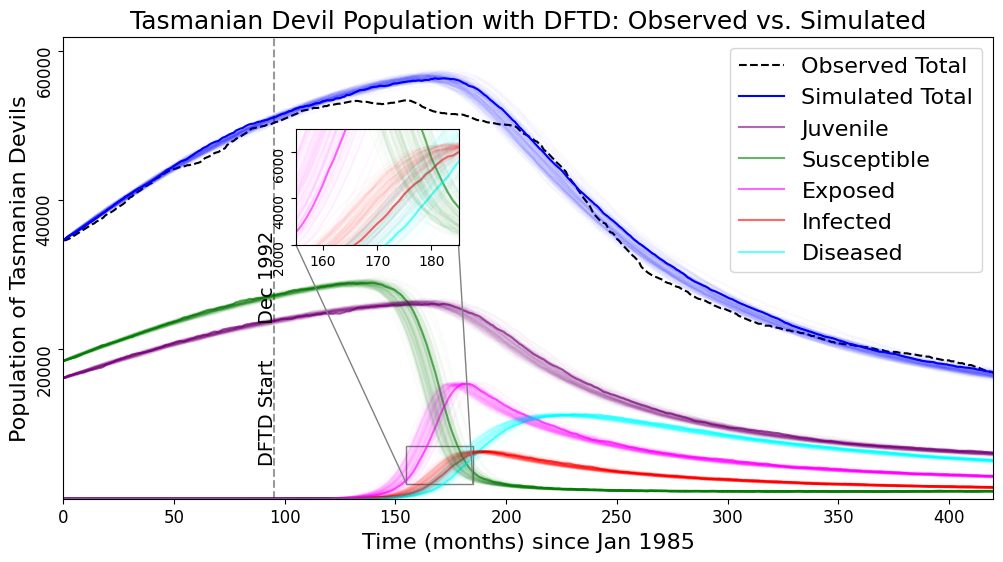

In [147]:
plot_eresult(eresults)

# Start Varying parameters

In [36]:
variables['incubation']=17

simulation complete in 45.42868947982788s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 4e-05, 'incubation': 17, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.024, 'DFTD_start': 95}


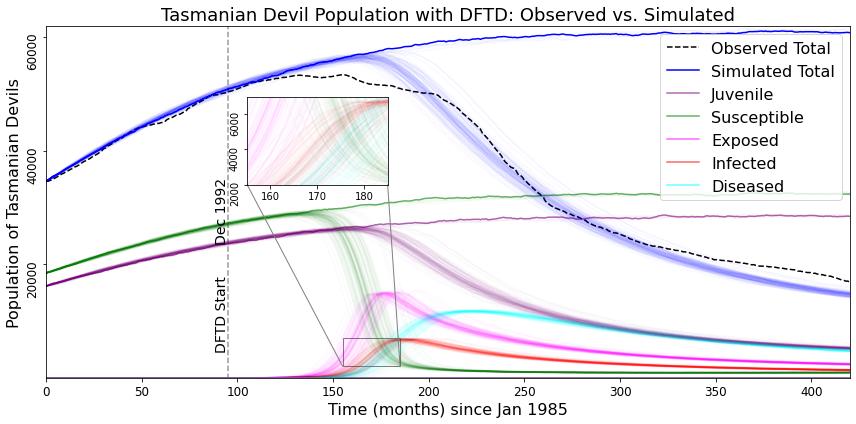

In [37]:
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 65.39260673522949s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 4e-05, 'incubation': 15, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


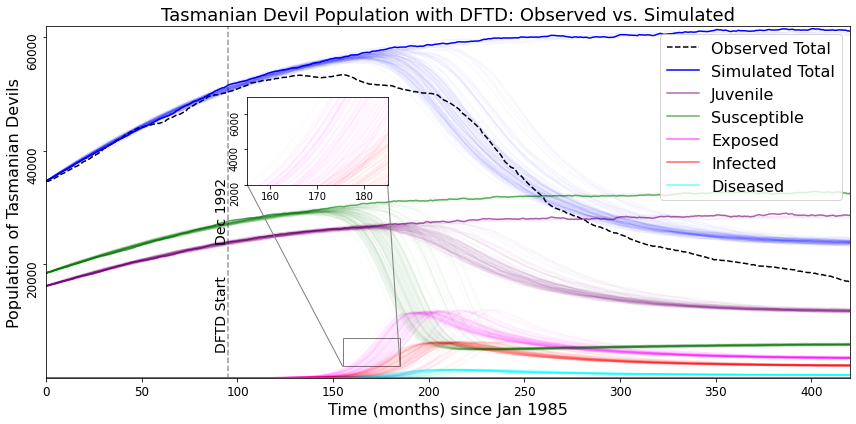

In [42]:
variables = variables_orig.copy()
variables['incubation']=15
variables['death_rate_diseased']=0.35
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 53.90875267982483s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 4e-05, 'incubation': 12, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


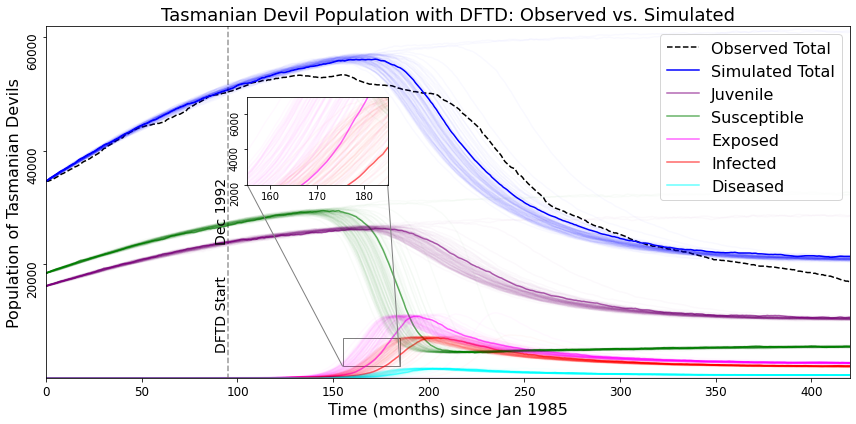

In [43]:
variables = variables_orig.copy()
variables['incubation']=12
variables['death_rate_diseased']=0.35
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 61.457836866378784s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 2e-05, 'incubation': 12, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


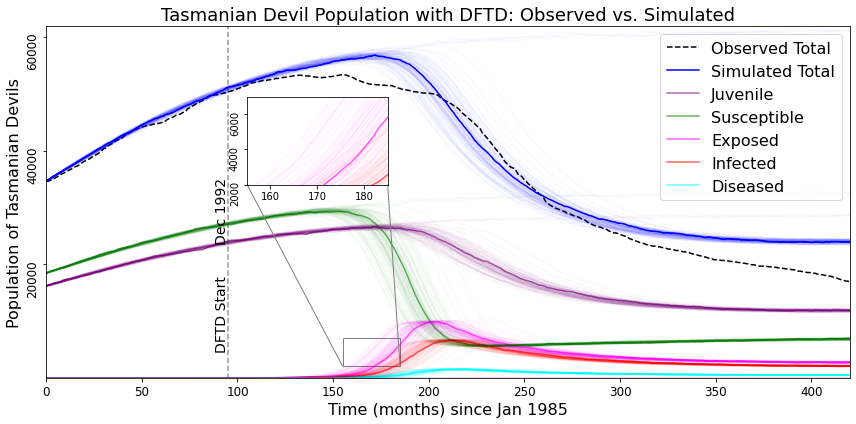

In [44]:
variables = variables_orig.copy()
variables['incubation']=12
variables['death_rate_diseased']=0.35
variables['infection_rate_diseased']=2e-05  #4e-05

###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 66.03158593177795s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1.675e-05, 'infection_rate_diseased': 3e-05, 'incubation': 12, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


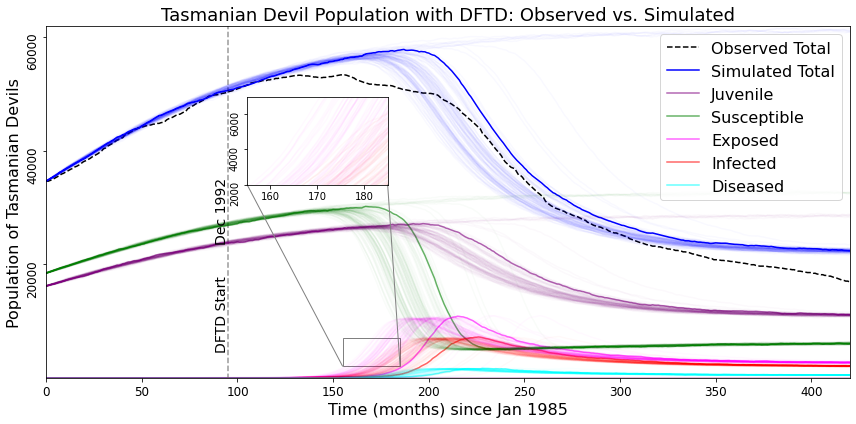

In [50]:
variables = variables_orig.copy()
variables['incubation']=12
variables['death_rate_diseased']=0.35
variables['infection_rate_diseased']=3e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 58.81425333023071s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 2e-05, 'infection_rate_diseased': 2e-05, 'incubation': 12, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


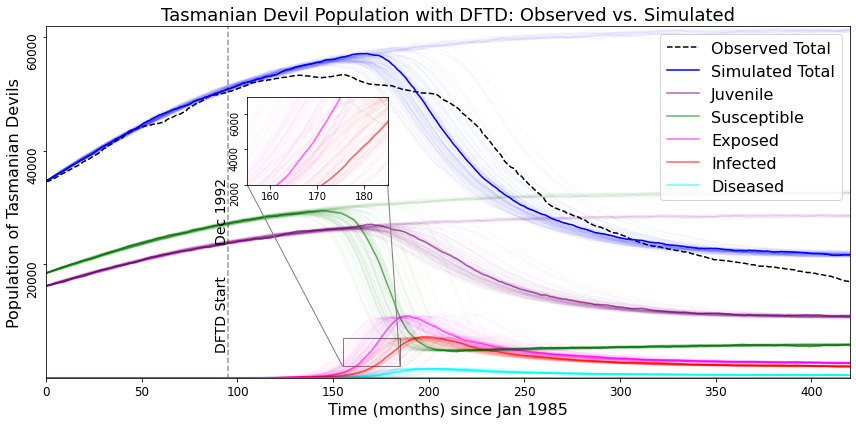

In [52]:
variables = variables_orig.copy()
variables['incubation']=12
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=2e-05  #1.675e-05,
variables['infection_rate_diseased']=2e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 50.39687132835388s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 2e-05, 'infection_rate_diseased': 2e-05, 'incubation': 11, 'progression': 11, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


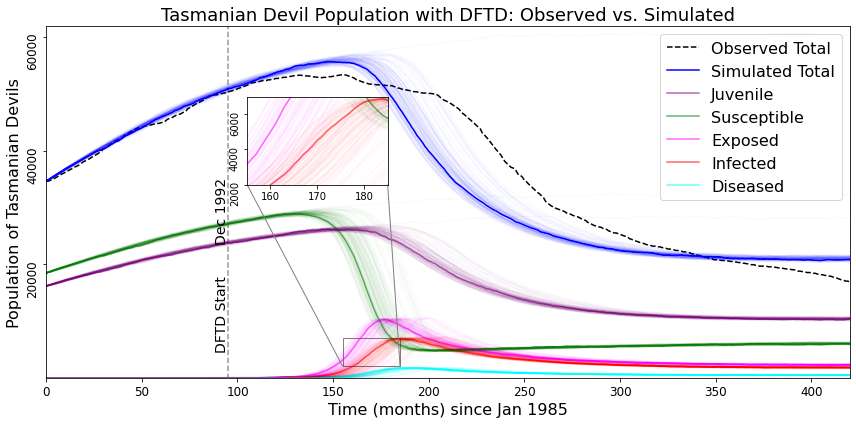

In [53]:
variables = variables_orig.copy()
variables['incubation']= 11
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=2e-05  #1.675e-05,
variables['infection_rate_diseased']=2e-05  
variables['progression'] = 11
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 66.83842492103577s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 2e-05, 'infection_rate_diseased': 2e-05, 'incubation': 9, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


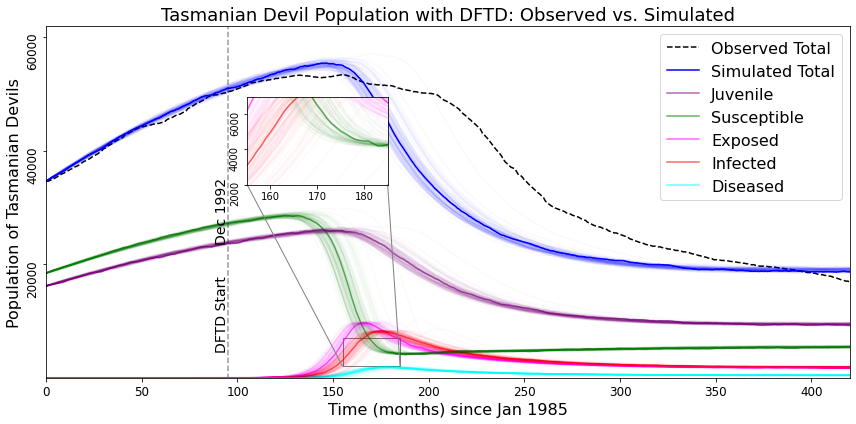

In [55]:
variables = variables_orig.copy()
variables['incubation']= 9
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=2e-05  #1.675e-05,
variables['infection_rate_diseased']=2e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 98.74420070648193s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1e-05, 'infection_rate_diseased': 2e-05, 'incubation': 9, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


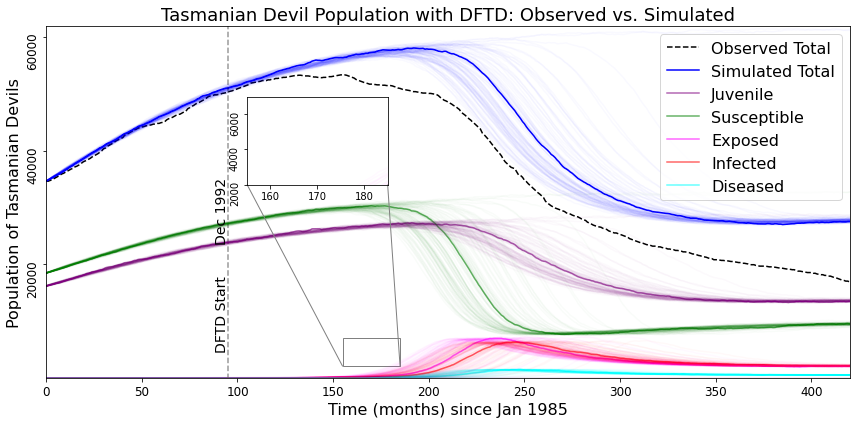

In [57]:
variables = variables_orig.copy()
variables['incubation']= 9
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=2e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 67.37930941581726s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1e-05, 'infection_rate_diseased': 2e-05, 'incubation': 6, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


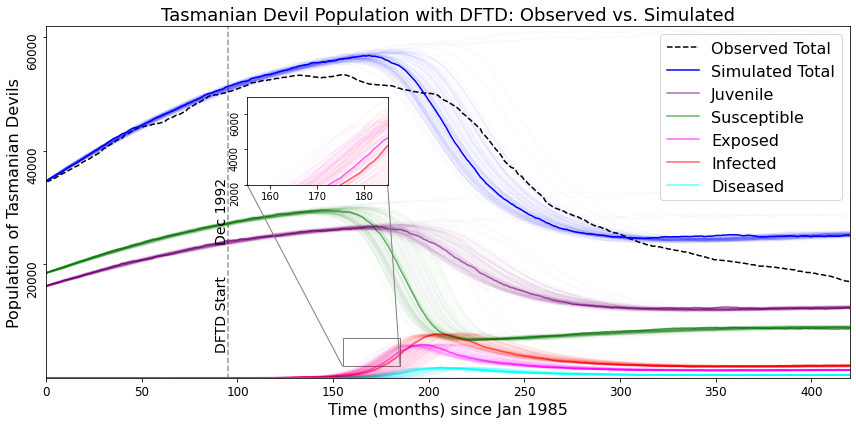

In [59]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=2e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

simulation complete in 85.03707838058472s


<ipython-input-33-e02427f50516>:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1e-05, 'infection_rate_diseased': 1e-05, 'incubation': 6, 'progression': 12, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.02, 'death_rate_diseased': 0.35, 'DFTD_start': 95}


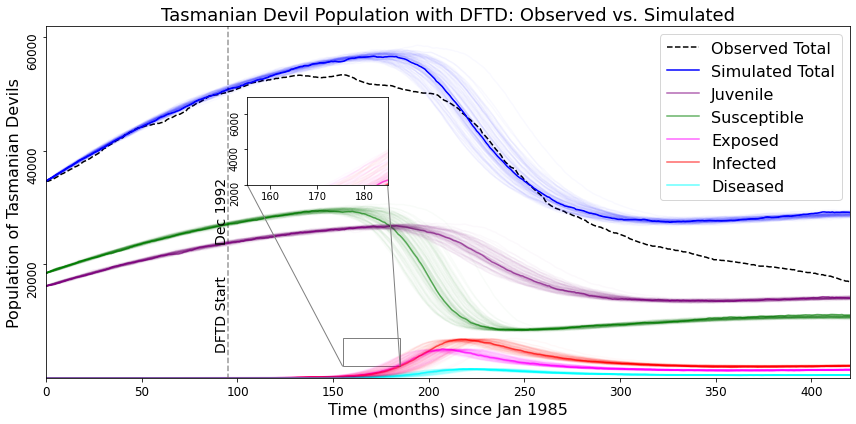

In [62]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=1e-05  
variables['progression'] = 12
###
emodel = DevilsPreVaccination(values=variables)
tic = time.time()
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
print(f"simulation complete in {time.time()-tic}s")
plot_eresult(eresults)

Running 100 trajectories  complete in 60.452571630477905s
Running 7 trajectories  complete in 1.733020544052124s
Running 5 trajectories  complete in 2.558332920074463s
Running 2 trajectories  complete in 1.1298117637634277s
'infection_rate_infected' = 1e-05
'infection_rate_diseased' = 1e-05
'incubation' = 6
'progression' = 10
'death_rate_diseased' = 0.35
L2 = 117037.13 +/-21662.44


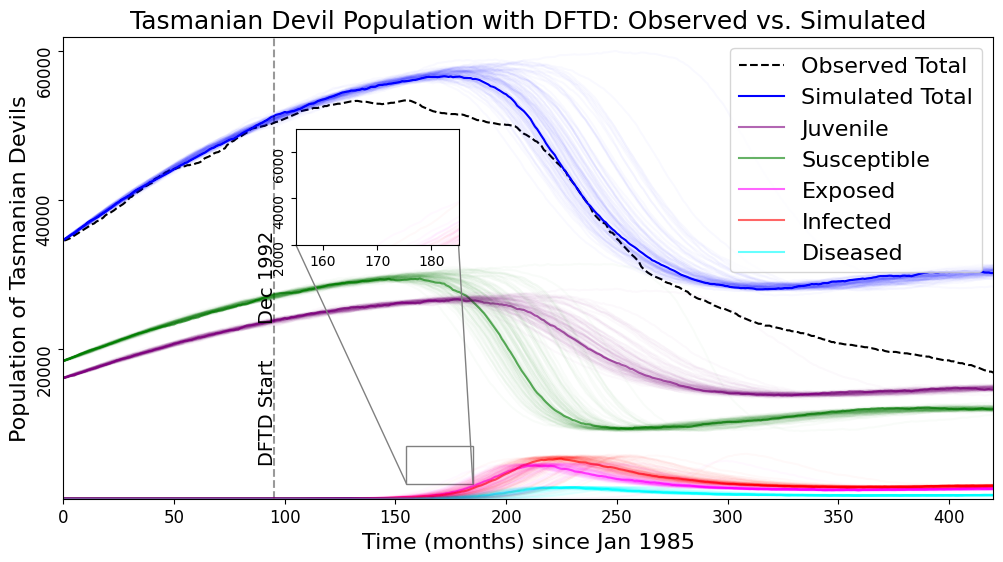

In [148]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=1e-05  
variables['progression'] = 10
###
emodel = DevilsPreVaccination(values=variables)
eresults = emodel.run(number_of_trajectories=100, solver=TauHybridCSolver)
plot_eresult(eresults)

Running 100 trajectories  complete in 73.23608136177063s
Running 6 trajectories  complete in 3.776925563812256s
Running 2 trajectories  complete in 1.4886536598205566s
'infection_rate_infected' = 1e-05
'infection_rate_diseased' = 1e-05
'incubation' = 6
'progression' = 10
'death_rate_diseased' = 0.35
'DFTD_start' = 40
L2 = 136175.47 +/-15641.94


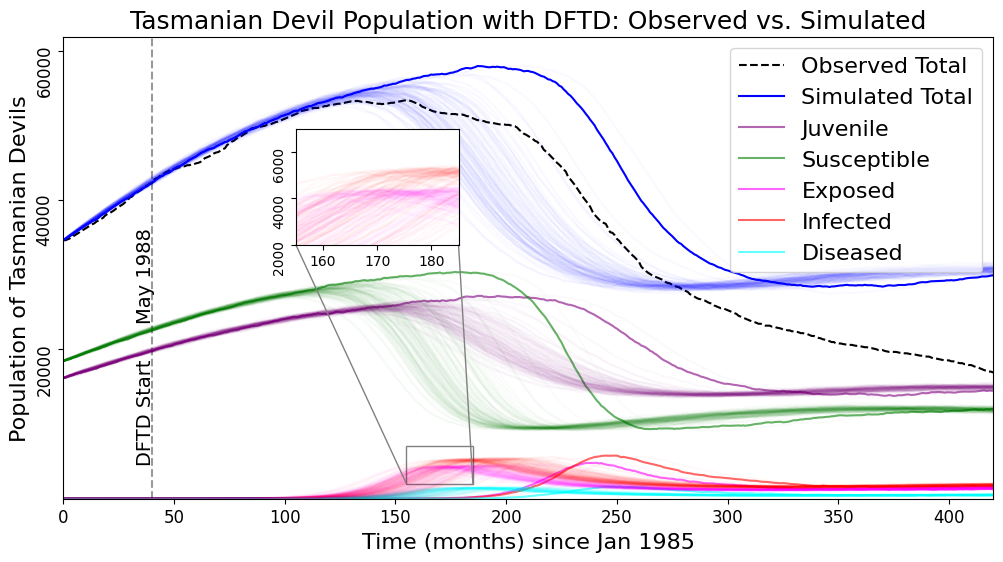

In [150]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=1e-05  
variables['progression'] = 10
variables['DFTD_start'] = 40

###
emodel = DevilsPreVaccination(values=variables)
eresults = emodel.run(number_of_trajectories=100)
plot_eresult(eresults)

Running 100 trajectories  complete in 39.71513223648071s
Running 86 trajectories  complete in 61.63770365715027s
{'juvenile_concentration': 0.467, 'infected_concentration': 5e-05, 'birth_rate': 0.055, 'maturity_rate': 0.04267, 'infection_rate_infected': 1e-05, 'infection_rate_diseased': 1e-05, 'incubation': 6, 'progression': 10, 'death_rate_juvenile': 0.006, 'death_rate_susceptible': 0.02335, 'death_rate_over_population': 2.3e-07, 'death_rate_infected': 0.03, 'death_rate_diseased': 0.35, 'DFTD_start': 40}
'infection_rate_infected' = 1e-05
'infection_rate_diseased' = 1e-05
'incubation' = 6
'progression' = 10
'death_rate_infected' = 0.03
'death_rate_diseased' = 0.35
'DFTD_start' = 40
L2 = 147205.88 +/-12967.30


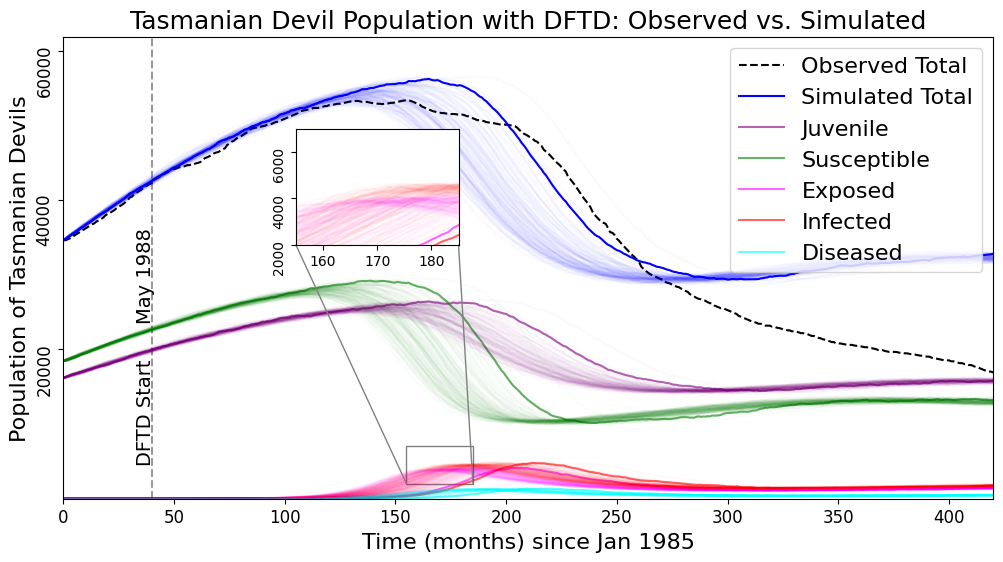

In [153]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_infected']=0.03
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=1e-05  
variables['progression'] = 10
variables['DFTD_start'] = 40

###
emodel = DevilsPreVaccination(values=variables)
eresults = emodel.run(number_of_trajectories=100)
plot_eresult(eresults)

Running 100 trajectories  complete in 32.614487171173096s
Running 100 trajectories  complete in 38.646796226501465s
Running 82 trajectories  complete in 8.301474332809448s
Running 82 trajectories  complete in 7.398047208786011s
Running 82 trajectories  complete in 46.187214851379395s
Running 52 trajectories  complete in 5.044662714004517s
Running 52 trajectories  complete in 22.297302961349487s
Running 41 trajectories  complete in 24.456116676330566s
Running 23 trajectories  complete in 10.155258417129517s
Running 18 trajectories  complete in 1.3200998306274414s
Running 18 trajectories  complete in 15.488996982574463s
Running 5 trajectories  complete in 0.45476245880126953s
Running 5 trajectories  complete in 2.3372044563293457s
Running 3 trajectories  complete in 3.1841952800750732s
Running 1 trajectories  complete in 0.12650465965270996s
Running 1 trajectories  complete in 0.11714410781860352s
Running 1 trajectories  complete in 0.471569299697876s
Running 1 trajectories  complete in 

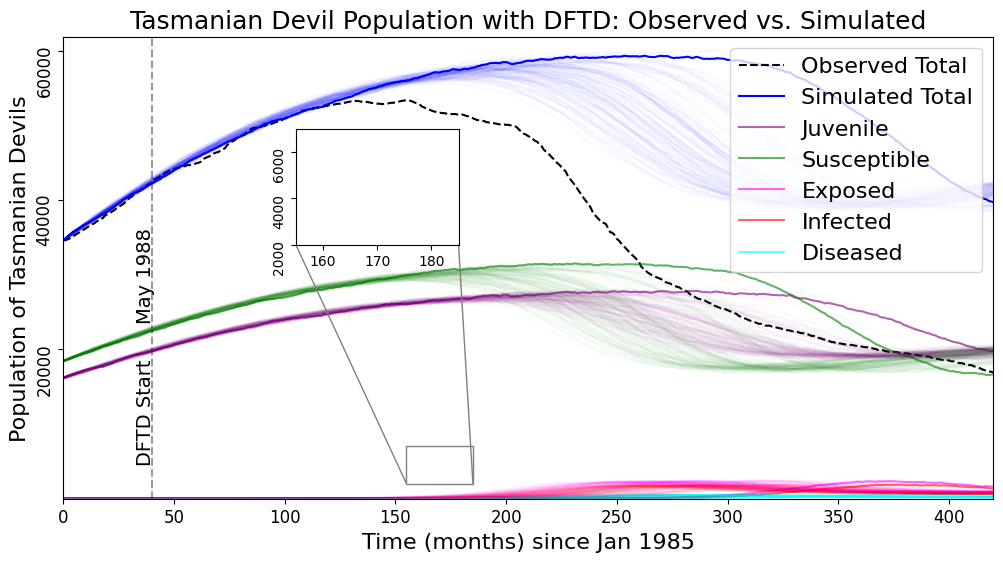

In [154]:
variables = variables_orig.copy()
variables['incubation']= 6
variables['death_rate_infected']=0.1
variables['death_rate_diseased']=0.35
variables['infection_rate_infected']=1e-05  #1.675e-05,
variables['infection_rate_diseased']=1e-05  
variables['progression'] = 10
variables['DFTD_start'] = 40

###
emodel = DevilsPreVaccination(values=variables)
eresults = emodel.run(number_of_trajectories=100)
plot_eresult(eresults)

In [72]:
1/6

0.16666666666666666

Sweeps below here

In [ ]:
raise Exception('STOP')

In [14]:
import numpy

In [15]:
ps_dftd_start_db={}

In [16]:
def sample_start_time(DFTD_start):
    global obs
    total_results = 100
    num_results = 0
    dists = numpy.zeros(total_results)
    while(num_results < total_results):
        ntraj = total_results-num_results
        print(f"\tRunning {ntraj}", end=' ')
        sys.stdout.flush()
        tic = time.time()
        eresults = event_model(DFTD_start=DFTD_start).run(number_of_trajectories=ntraj, solver=TauHybridCSolver)
        print(f"\tsimulation complete in {time.time()-tic}s")
        for r in eresults:
            if (r['Exposed'][-1] + r['Infected'][-1] + r['Diseased'][-1]) > 0:
                dists[num_results] = numpy.linalg.norm(r['Devils']-obs[0][0],2)
                num_results+=1
    d = numpy.average(dists)
    print(f"DFTD_start={DFTD_start} L2={d}")
    return d

In [17]:
ps_dftd_start_sweep=[40, 50, 60, 70, 75, 80,82,84,86,88,90,92,94,95,96,98, 100,101, 105,110,120]

In [18]:
for dftd_start in ps_dftd_start_sweep:
    if dftd_start in ps_dftd_start_db:
        print(f"dftd_start={dftd_start} already calculated L2={ps_dftd_start_db[dftd_start]}")
    else:
        print(f"Running dftd_start={dftd_start}")
        ps_dftd_start_db[dftd_start] = sample_start_time(dftd_start)

Running dftd_start=40
	Running 100 	simulation complete in 46.88654971122742s
DFTD_start=40 L2=149725.92964844173
Running dftd_start=50
	Running 100 	simulation complete in 55.0531530380249s
DFTD_start=50 L2=110207.5635610247
Running dftd_start=60
	Running 100 	simulation complete in 55.84318971633911s
	Running 1 	simulation complete in 12.524021863937378s
DFTD_start=60 L2=78908.23939708289
Running dftd_start=70
	Running 100 	simulation complete in 59.662312746047974s
DFTD_start=70 L2=51566.26250616014
Running dftd_start=75
	Running 100 	simulation complete in 45.953802824020386s
DFTD_start=75 L2=70940.11014971728
Running dftd_start=80
	Running 100 	simulation complete in 55.67413592338562s
DFTD_start=80 L2=41698.95949174238
Running dftd_start=82
	Running 100 	simulation complete in 64.22798705101013s
	Running 44 	simulation complete in 30.08085799217224s
DFTD_start=82 L2=54044.03944016575
Running dftd_start=84
	Running 100 	simulation complete in 51.160480976104736s
	Running 13 	simul

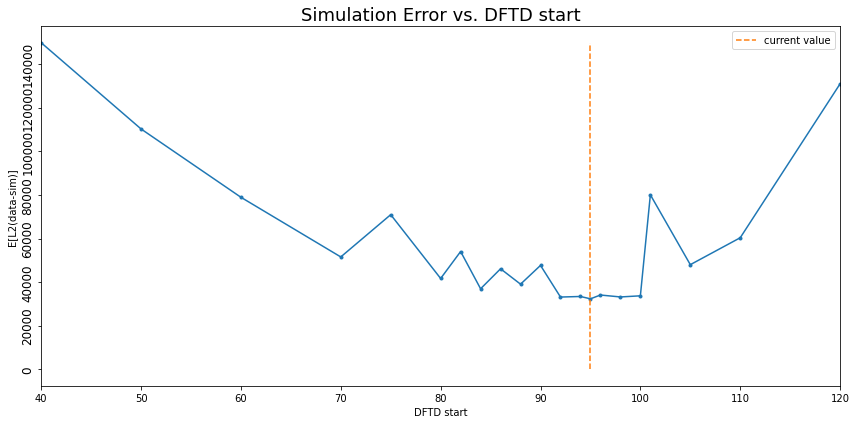

In [19]:
ps_dftd_start_dist=[]
for dftd_start in ps_dftd_start_sweep:
    ps_dftd_start_dist.append(ps_dftd_start_db[dftd_start])

plt.figure(figsize=[12, 6])
plt.title("Simulation Error vs. DFTD start", fontsize=18)
    
plt.plot(ps_dftd_start_sweep,ps_dftd_start_dist,'.-')
plt.xlabel('DFTD start')
plt.ylabel("E[L2(data-sim)]")
plt.yticks(fontsize=12, rotation="vertical", va="center")
plt.xlim(ps_dftd_start_sweep[0],ps_dftd_start_sweep[-1])
plt.tight_layout()
current_val = variables['DFTD_start']
plt.plot([current_val, current_val],[0,max(ps_dftd_start_dist)], '--',label="current value")
plt.legend()
plt.savefig("SimError-vs-DFTD_start.pdf")

In [20]:
maxval=math.inf
maxkey=''
for k,v in ps_dftd_start_db.items():
    if v<maxval:
        maxkey=k
        maxval=v
print(f"Selected value {maxkey}")

Selected value 95
